# Cellular automaton - Rendu Intelligence Distribuée

##### Colin Decourt - Bordeaux INP ENSEIRB-MATMECA
Engineering student in artificial intelligence


###### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import datetime
import cv2 as cv
from tqdm import tqdm
import seaborn as sb
%matplotlib inline

##### Utils functions

In [2]:
def create_gif(filenames, duration, name):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    output_file = 'Gif-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimsave('./gif/'+name+output_file, images, duration=duration)

In [3]:
def get_neighbours_indices(forest, cell, valid_cells):
    '''
    Function which get all the valid neighbours of a given cell
    :forest: the forest grid
    :cell: cell's neighbours
    :valid_cells: all the valid coordinates of the forest grid
    '''
    X = [-1, -1, 0, 1, 1, 1, 0, -1]
    Y = [0, 1, 1, 1, 0, -1, -1, -1]
    neighbours_list = []
    
    for k in range(len(X)):
        temp_cell = (cell[0] + X[k], cell[1] + Y[k])
        if temp_cell in valid_cells:
            neighbours_list.append(temp_cell)
    return neighbours_list
            

In [4]:
def valid_cells(forest):
    '''
    Function which get all the coordinates of the grid
    :forest: the forest grid
    '''
    valid_cells = []
    for i in range(forest.shape[0]):
        for j in range(forest.shape[1]):
            valid_cells.append((i,j))
    return valid_cells

##### Parameters

In [5]:
australia = False
# Use for evaluate density impact
test = True

if australia:
    # Australia forest parameters

    cells = {'ocean':0, 'closed_forest':1, 'open_forest':2, 'woodland':3, 'herbland':4, 'desert': 5, 'fire': 6, 'ash': 7}
    density = {'closed_forest': 0.35, 'open_forest': 0.55, 'woodland':0.75, 'herbland': 0.1}

    # Display parameters
    pallette = np.array( [[0, 170, 255],# ocean
                          [0, 77, 13],  # closed forest
                          [0, 230, 0],  # open forest
                          [179, 89, 0], # woodland
                          [204, 230, 255], # herbland
                          [255, 179, 102], # desert
                          [230, 115, 0],   # fire
                          [158, 158, 158] # ash
                          ])

else:
    if test: 
        cells = {'empty':0, 'tree1':1, 'tree2':2, 'tree3':3, 'tree4':4, 'tree6': 6, 'tree7': 7, 'tree7':8, 'tree8': 9, 'fire': 10, 'ash': 11}
        density = {'tree1': 0.15, 'tree2': 0.25 , 'tree3':0.35, 'tree4': 0.45, 'tree5': 0.55, 'tree6': 0.65, 'tree7': 0.75, 'tree7':0.85, 'tree8': 0.85}
    else:
        cells = {'empty':0, 'tree1':1, 'tree2':2, 'tree3':3, 'tree4':4, 'fire': 5, 'ash': 6}
        density = {'tree1': 0.35, 'tree2': 0.45 , 'tree3':0.55, 'tree4': 0.65}
    grid_size = (50, 50)
    
    # Display parameters
    pallette = np.array( [[153, 102, 0],# empty
                          [0, 51, 8],  # tree1
                          [0, 153, 25],  # tree2
                          [0, 230, 0], # tree3
                          [149, 255, 128], # tree4
                          [230, 115, 0],   # fire
                          [158, 158, 158] # ash
                          ])


In [6]:
def generate_forest(grid_size, max_start_fire):
    forest = np.zeros(grid_size, dtype=int)
    no_change = []
    num_fire = 0
    tree1 = 0
    tree2 = 0
    tree3 = 0
    tree4 = 0
    exist = valid_cells(forest)
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if (i,j) not in no_change:
                type_cell = np.random.randint(low=0, high=10)
                if type_cell == 0:
                    # Une chance sur 30 d'avoir une clairière
                    clear = np.random.randint(low=0, high=30)
                    forest[i,j] = cells['empty']
                    if clear == 12:
                        neigh_list = get_neighbours_indices(forest, (i,j), exist)
                        for neigh in neigh_list:
                            no_change.append(neigh)
                            forest[neigh] = cells['empty']
                if type_cell == 1 or type_cell ==2:
                    forest[i,j] = cells['tree1']
                    tree1 += 1
                if type_cell == 3 or type_cell == 4:
                    forest[i,j] = cells['tree2']
                    tree2 += 1
                if type_cell == 5 or type_cell == 6:
                    forest[i,j] = cells['tree3']
                    tree3 += 1
                if type_cell == 7 or type_cell == 8:
                    forest[i,j] = cells['tree4']
                    tree4 += 1
                if type_cell == 9 and num_fire < max_start_fire:
                    forest[i,j] = cells['fire']
                    num_fire += 1
    print('Generate forest with', num_fire, 'start of fire')
    initial_forest = {'fire': num_fire, 'ash': 0, 'tree1':tree1 , 'tree2': tree2, 'tree3': tree3, 'tree4': tree4}
    return forest, initial_forest

##### Transition functions

Transition rules : 

- An empty cell stay empty
- A ash cell stay ash
- A fire cell become ash
- A tree cell :
    - Become fire if one of them neighbour is in fire
    - Stay tree otherwise

In [8]:
def may_burn_tree(forest, cell, cell_type, state):
    to_burn = []
    no_burn = []

    neigh_list = get_neighbours_indices(forest, cell, EXIST_CELLS)
    for neigh_cell in neigh_list:
        if forest[neigh_cell] == cells['fire']:
            to_burn.append(neigh_cell)       
        else:
            no_burn.append(neigh_cell)
    seuil = np.random.random()
    if to_burn == [] or seuil > density[cell_type]:
        return cells[cell_type], state
    else:
        state[cell_type]-=1
        state['fire'] += 1
        return cells['fire'], state

In [9]:
def transition_australia(forest, cell, state):
    '''
    Function which return the future state of a given cell
    :forest: the forest grid
    :cell: cell's future state wanted
    :state: state of the country at current step
    '''
    try:
        if forest[cell] == cells['ocean']:
            return cells['ocean'], state

        if forest[cell] == cells['desert']:
            return cells['desert'], state

        if forest[cell] == cells['ash']:
            return cells['ash'], state

        if forest[cell] == cells['closed_forest']:
            return may_burn(forest, cell, 'closed_forest', state)

        if forest[cell] == cells['open_forest']:
            return may_burn(forest, cell, 'open_forest', state)

        if forest[cell] == cells['woodland']:
            return may_burn(forest, cell, 'woodland', state)

        if forest[cell] == cells['herbland']:
            return may_burn(forest, cell, 'herbland', state)

        if forest[cell] == cells['fire']:
            state['fire']-=1
            state['ash'] +=1
            return cells['ash'], state
        
    except:
        print('Unknown cell type. Abort.')
    
    

In [10]:
def transition_general(forest, cell, state):
    '''
    Function which return the future state of a given cell
    :forest: the forest grid
    :cell: cell's future state wanted
    :state: state of the country at current step
    '''
    try:
        if forest[cell] == cells['empty']:
            return cells['empty'], state

        if forest[cell] == cells['ash']:
            return cells['ash'], state

        if forest[cell] == cells['tree1']:
            return may_burn(forest, cell, 'tree1', state)

        if forest[cell] == cells['tree2']:
            return may_burn(forest, cell, 'tree2', state)

        if forest[cell] == cells['tree3']:
            return may_burn(forest, cell, 'tree3', state)

        if forest[cell] == cells['tree4']:
            return may_burn(forest, cell, 'tree4', state)

        if forest[cell] == cells['fire']:
            state['fire']-=1
            state['ash'] +=1
            return cells['ash'], state
        
    except:
        print('Unknown cell type. Abort.')
    
    

##### Fire propagation

In [11]:
def step(forest, is_fire, state):
    '''
    Function which perfom one propagation step
    :forest: the forest grid
    :is_fire: boolean informing the fire state - True : still cell in fire False otherwise
    '''
    nb_fire = 0
    new_forest = forest.copy()
    new_state = state.copy()
    for i in range(forest.shape[0]):
        for j in range(forest.shape[1]):
            if australia:
                cell_type, new_state = transition_australia(forest, (i,j), new_state)
            else:
                cell_type, new_state = transition_general(forest, (i,j), new_state)
            new_forest[i,j] = cell_type
            if new_forest[i,j] == cells['fire']:
                nb_fire += 1
    print(nb_fire)
    if nb_fire == 0:
        is_fire = False
    return new_forest, is_fire, new_state

In [12]:
# Reset images
for name in os.listdir():
    if name[-3:] == 'png':
        if name != 'aust-veg-map.png':
            os.remove(name)

## Fire forest on random grid

In [14]:
grid_list = [(10,10), (20, 20), (30, 30), (40, 40), (50, 50), (100, 100)]

for grid_size in grid_list:
    forest, initial_state = generate_forest(grid_size, 100)
    EXIST_CELLS = valid_cells(forest)
    is_fire = True
    state_list =[]
    state_list.append(initial_state)
    num_step = 0
    plt.figure(figsize=(10,10))
    plt.imshow(pallette[forest])
    plt.savefig(str(num_step)+'.png')
    plt.clf()
    while(1):
        print('--- STEP',num_step,'begin ---')
        forest, is_fire, state = step(forest, is_fire, state_list[num_step])
        print('New state:',state)
        state_list.append(state.copy())
        num_step+=1
        plt.figure(figsize=(10,10))
        plt.imshow(pallette[forest])
        plt.savefig(str(num_step)+'.png')
        plt.clf()
        if is_fire is False:
            print('Fire is dead...')
            break
    np.save('./data/state_list_'+str(grid_size), state_list)
    filenames = []
    for name in os.listdir():
        if name[-3:] == 'png':
            if name != 'aust-veg-map.png':
                filenames.append(name)
    filenames.sort(key=lambda x: float(x[:-4]))

    create_gif(filenames, duration=0.8, name=str(grid_size))
    # Reset images
    for name in os.listdir():
        if name[-3:] == 'png':
            if name != 'aust-veg-map.png':
                os.remove(name)

Generate forest with 11 start of fire
--- STEP 0 begin ---
25
New state: {'fire': 25, 'ash': 11, 'tree1': 7, 'tree2': 11, 'tree3': 14, 'tree4': 19}
--- STEP 1 begin ---
24
New state: {'fire': 24, 'ash': 36, 'tree1': 4, 'tree2': 9, 'tree3': 9, 'tree4': 5}
--- STEP 2 begin ---
12
New state: {'fire': 12, 'ash': 60, 'tree1': 4, 'tree2': 5, 'tree3': 3, 'tree4': 3}
--- STEP 3 begin ---
4
New state: {'fire': 4, 'ash': 72, 'tree1': 2, 'tree2': 3, 'tree3': 3, 'tree4': 3}
--- STEP 4 begin ---
2
New state: {'fire': 2, 'ash': 76, 'tree1': 1, 'tree2': 3, 'tree3': 2, 'tree4': 3}
--- STEP 5 begin ---
2
New state: {'fire': 2, 'ash': 78, 'tree1': 1, 'tree2': 2, 'tree3': 1, 'tree4': 3}
--- STEP 6 begin ---
0
New state: {'fire': 0, 'ash': 80, 'tree1': 1, 'tree2': 2, 'tree3': 1, 'tree4': 3}
Fire is dead...
Generate forest with 33 start of fire
--- STEP 0 begin ---
75
New state: {'fire': 76, 'ash': 32, 'tree1': 68, 'tree2': 81, 'tree3': 61, 'tree4': 47}
--- STEP 1 begin ---
74
New state: {'fire': 75, 'ash'

/Users/cdecourt/anaconda3/envs/ia/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


189
New state: {'fire': 191, 'ash': 243, 'tree1': 101, 'tree2': 115, 'tree3': 84, 'tree4': 69}
--- STEP 2 begin ---
127
New state: {'fire': 129, 'ash': 432, 'tree1': 77, 'tree2': 74, 'tree3': 52, 'tree4': 39}
--- STEP 3 begin ---
81
New state: {'fire': 83, 'ash': 559, 'tree1': 59, 'tree2': 49, 'tree3': 34, 'tree4': 19}
--- STEP 4 begin ---
36
New state: {'fire': 38, 'ash': 640, 'tree1': 44, 'tree2': 43, 'tree3': 21, 'tree4': 17}
--- STEP 5 begin ---
16
New state: {'fire': 18, 'ash': 676, 'tree1': 39, 'tree2': 39, 'tree3': 18, 'tree4': 13}
--- STEP 6 begin ---
5
New state: {'fire': 7, 'ash': 692, 'tree1': 36, 'tree2': 38, 'tree3': 18, 'tree4': 12}
--- STEP 7 begin ---
3
New state: {'fire': 5, 'ash': 697, 'tree1': 35, 'tree2': 37, 'tree3': 17, 'tree4': 12}
--- STEP 8 begin ---
0
New state: {'fire': 2, 'ash': 700, 'tree1': 35, 'tree2': 37, 'tree3': 17, 'tree4': 12}
Fire is dead...
Generate forest with 100 start of fire
--- STEP 0 begin ---


/Users/cdecourt/anaconda3/envs/ia/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


231
New state: {'fire': 235, 'ash': 96, 'tree1': 278, 'tree2': 269, 'tree3': 242, 'tree4': 232}
--- STEP 1 begin ---
202
New state: {'fire': 206, 'ash': 327, 'tree1': 231, 'tree2': 221, 'tree3': 196, 'tree4': 171}
--- STEP 2 begin ---
152
New state: {'fire': 156, 'ash': 529, 'tree1': 207, 'tree2': 184, 'tree3': 156, 'tree4': 120}
--- STEP 3 begin ---
110
New state: {'fire': 114, 'ash': 681, 'tree1': 169, 'tree2': 158, 'tree3': 127, 'tree4': 103}
--- STEP 4 begin ---
69
New state: {'fire': 73, 'ash': 791, 'tree1': 153, 'tree2': 135, 'tree3': 112, 'tree4': 88}
--- STEP 5 begin ---
36
New state: {'fire': 40, 'ash': 860, 'tree1': 143, 'tree2': 128, 'tree3': 101, 'tree4': 80}
--- STEP 6 begin ---
26
New state: {'fire': 30, 'ash': 896, 'tree1': 134, 'tree2': 122, 'tree3': 94, 'tree4': 76}
--- STEP 7 begin ---
18
New state: {'fire': 22, 'ash': 922, 'tree1': 132, 'tree2': 115, 'tree3': 88, 'tree4': 73}
--- STEP 8 begin ---
20
New state: {'fire': 24, 'ash': 940, 'tree1': 131, 'tree2': 105, 'tre

2
New state: {'fire': 2, 'ash': 1505, 'tree1': 174, 'tree2': 152, 'tree3': 128, 'tree4': 105}
--- STEP 45 begin ---
3
New state: {'fire': 3, 'ash': 1507, 'tree1': 171, 'tree2': 152, 'tree3': 128, 'tree4': 105}
--- STEP 46 begin ---
5
New state: {'fire': 5, 'ash': 1510, 'tree1': 171, 'tree2': 151, 'tree3': 128, 'tree4': 101}
--- STEP 47 begin ---
5
New state: {'fire': 5, 'ash': 1515, 'tree1': 171, 'tree2': 150, 'tree3': 128, 'tree4': 97}
--- STEP 48 begin ---
9
New state: {'fire': 9, 'ash': 1520, 'tree1': 170, 'tree2': 149, 'tree3': 126, 'tree4': 92}
--- STEP 49 begin ---
8
New state: {'fire': 8, 'ash': 1529, 'tree1': 167, 'tree2': 147, 'tree3': 123, 'tree4': 92}
--- STEP 50 begin ---
5
New state: {'fire': 5, 'ash': 1537, 'tree1': 165, 'tree2': 144, 'tree3': 123, 'tree4': 92}
--- STEP 51 begin ---
4
New state: {'fire': 4, 'ash': 1542, 'tree1': 164, 'tree2': 143, 'tree3': 122, 'tree4': 91}
--- STEP 52 begin ---
4
New state: {'fire': 4, 'ash': 1546, 'tree1': 163, 'tree2': 142, 'tree3': 12

88
New state: {'fire': 90, 'ash': 2649, 'tree1': 1427, 'tree2': 1353, 'tree3': 1342, 'tree4': 1221}
--- STEP 36 begin ---
72
New state: {'fire': 74, 'ash': 2737, 'tree1': 1411, 'tree2': 1342, 'tree3': 1319, 'tree4': 1199}
--- STEP 37 begin ---
90
New state: {'fire': 92, 'ash': 2809, 'tree1': 1386, 'tree2': 1320, 'tree3': 1300, 'tree4': 1175}
--- STEP 38 begin ---
76
New state: {'fire': 78, 'ash': 2899, 'tree1': 1372, 'tree2': 1300, 'tree3': 1277, 'tree4': 1156}
--- STEP 39 begin ---
80
New state: {'fire': 82, 'ash': 2975, 'tree1': 1360, 'tree2': 1279, 'tree3': 1249, 'tree4': 1137}
--- STEP 40 begin ---
67
New state: {'fire': 69, 'ash': 3055, 'tree1': 1345, 'tree2': 1264, 'tree3': 1229, 'tree4': 1120}
--- STEP 41 begin ---
64
New state: {'fire': 66, 'ash': 3122, 'tree1': 1334, 'tree2': 1253, 'tree3': 1211, 'tree4': 1096}
--- STEP 42 begin ---
59
New state: {'fire': 61, 'ash': 3186, 'tree1': 1319, 'tree2': 1236, 'tree3': 1195, 'tree4': 1085}
--- STEP 43 begin ---
52
New state: {'fire': 5

34
New state: {'fire': 36, 'ash': 6835, 'tree1': 504, 'tree2': 320, 'tree3': 231, 'tree4': 156}
--- STEP 105 begin ---
40
New state: {'fire': 42, 'ash': 6869, 'tree1': 497, 'tree2': 307, 'tree3': 220, 'tree4': 147}
--- STEP 106 begin ---
30
New state: {'fire': 32, 'ash': 6909, 'tree1': 492, 'tree2': 298, 'tree3': 209, 'tree4': 142}
--- STEP 107 begin ---
34
New state: {'fire': 36, 'ash': 6939, 'tree1': 484, 'tree2': 295, 'tree3': 200, 'tree4': 128}
--- STEP 108 begin ---
23
New state: {'fire': 25, 'ash': 6973, 'tree1': 477, 'tree2': 289, 'tree3': 198, 'tree4': 120}
--- STEP 109 begin ---
20
New state: {'fire': 22, 'ash': 6996, 'tree1': 472, 'tree2': 283, 'tree3': 193, 'tree4': 116}
--- STEP 110 begin ---
12
New state: {'fire': 14, 'ash': 7016, 'tree1': 468, 'tree2': 279, 'tree3': 189, 'tree4': 116}
--- STEP 111 begin ---
9
New state: {'fire': 11, 'ash': 7028, 'tree1': 464, 'tree2': 278, 'tree3': 186, 'tree4': 115}
--- STEP 112 begin ---
3
New state: {'fire': 5, 'ash': 7037, 'tree1': 46

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [ ]:
filenames = []
for name in os.listdir():
    if name[-3:] == 'png':
        if name != 'aust-veg-map.png':
            filenames.append(name)
filenames.sort(key=lambda x: float(x[:-4]))

create_gif(filenames, duration=0.8)

### Data analyse

In [15]:
density_val = [0.35, 0.45, 0.55, 0.65]

In [16]:
def get_data(data):
    fire_list = []
    tree1_list = []
    ash_list = []
    tree2_list = []
    tree3_list = []
    tree4_list = []
    for i in range(len(data)):
        fire_list.append(data[i]['fire'])
        tree1_list.append(data[i]['tree1'])
        ash_list.append(data[i]['ash'])
        tree2_list.append(data[i]['tree2'])
        tree3_list.append(data[i]['tree3'])
        tree4_list.append(data[i]['tree4'])
    return tree1_list, tree2_list, tree3_list, tree4_list, fire_list, ash_list

In [25]:
def get_burned_trees(tree_list):
    burn_list = (tree_list[0]-tree_list[-1])*100/tree_list[0]
    return burn_list

def get_remain_trees(tree_list):
    remain_list = (tree_list[-1])*100/tree_list[0]
    return remain_list

In [18]:
grid10 = get_data(np.load('data/state_list_(10, 10).npy', allow_pickle=True))
grid20 = get_data(np.load('data/state_list_(20, 20).npy', allow_pickle=True))
grid30 = get_data(np.load('data/state_list_(30, 30).npy', allow_pickle=True))
grid40 = get_data(np.load('data/state_list_(40, 40).npy', allow_pickle=True))
grid50 = get_data(np.load('data/state_list_(50, 50).npy', allow_pickle=True))
grid100 = get_data(np.load('data/state_list_(100, 100).npy', allow_pickle=True))

In [19]:
burn_trees10 = [get_burned_trees(grid10[i]) for i in range(4)]
burn_trees20 = [get_burned_trees(grid20[i]) for i in range(4)]
burn_trees30 = [get_burned_trees(grid30[i]) for i in range(4)]
burn_trees40 = [get_burned_trees(grid40[i]) for i in range(4)]
burn_trees50 = [get_burned_trees(grid50[i]) for i in range(4)]
burn_trees100 = [get_burned_trees(grid100[i]) for i in range(4)]

In [26]:
rem_trees10 = [get_remain_trees(grid10[i]) for i in range(4)]
rem_trees20 = [get_remain_trees(grid20[i]) for i in range(4)]
rem_trees30 = [get_remain_trees(grid30[i]) for i in range(4)]
rem_trees40 = [get_remain_trees(grid40[i]) for i in range(4)]
rem_trees50 = [get_remain_trees(grid50[i]) for i in range(4)]
rem_trees100 = [get_remain_trees(grid100[i]) for i in range(4)]

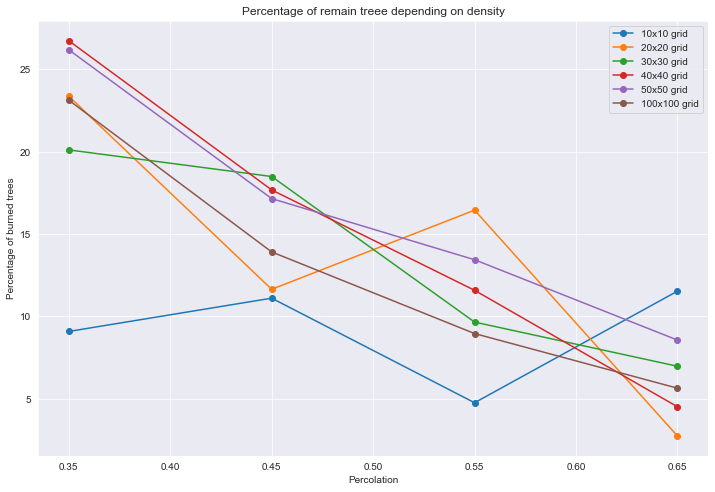

In [29]:
plt.figure(figsize=(12,8))
sb.set_style('darkgrid')
plt.plot(density_val, rem_trees10, '-o')
plt.plot(density_val, rem_trees20, '-o')
plt.plot(density_val, rem_trees30, '-o')
plt.plot(density_val, rem_trees40, '-o')
plt.plot(density_val, rem_trees50, '-o')
plt.plot(density_val, rem_trees100, '-o')
plt.xlabel('Percolation')
plt.ylabel('Percentage of burned trees')
plt.title('Percentage of remain treee depending on density')
plt.legend(('10x10 grid', '20x20 grid', '30x30 grid', '40x40 grid', '50x50 grid', '100x100 grid'))
plt.savefig('./data/remain_tree_density.png')
plt.show()

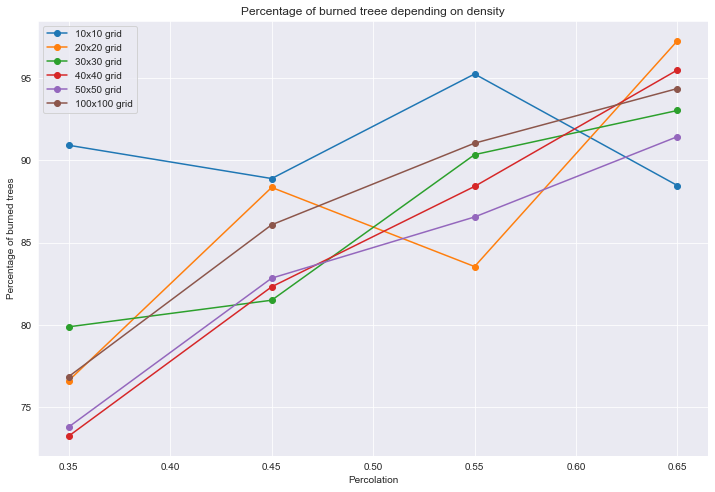

In [22]:
plt.figure(figsize=(12,8))
sb.set_style('darkgrid')
plt.plot(density_val, burn_trees10, '-o')
plt.plot(density_val, burn_trees20, '-o')
plt.plot(density_val, burn_trees30, '-o')
plt.plot(density_val, burn_trees40, '-o')
plt.plot(density_val, burn_trees50, '-o')
plt.plot(density_val, burn_trees100, '-o')
plt.xlabel('Percolation')
plt.ylabel('Percentage of burned trees')
plt.title('Percentage of burned treee depending on density')
plt.legend(('10x10 grid', '20x20 grid', '30x30 grid', '40x40 grid', '50x50 grid', '100x100 grid'))
plt.savefig('./data/burned_tree_density.png')
plt.show()

## Pray for Australia

Just few lines for simulate fire forest propagation in australia depending on tree density (percolation threshold). To do that an map of forest in Australia was load and process for generating a pseudo realistic map. 

All of this is just humour.  

In [39]:
# Australia forest parameters

cells = {'ocean':0, 'closed_forest':1, 'open_forest':2, 'woodland':3, 'herbland':4, 'desert': 5, 'fire': 6, 'ash': 7}
density = {'closed_forest': 0.35, 'open_forest': 0.55, 'woodland':0.75, 'herbland': 0.1}

# Display parameters
pallette = np.array( [[0, 170, 255],# ocean
                      [0, 77, 13],  # closed forest
                      [0, 230, 0],  # open forest
                      [179, 89, 0], # woodland
                      [204, 230, 255], # herbland
                      [255, 179, 102], # desert
                      [230, 115, 0],   # fire
                      [158, 158, 158] # ash
                      ])

##### Australia generation

![](https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fs3.thingpic.com%2Fimages%2FJe%2Fd6AyKkxRJmvwSHPpsPysVwhZ.gif&f=1&nofb=1)

In [14]:
def generate_australia(australia, max_start_fire):
    num_start_fire = 0
    new = australia.copy()
    sl = 35
    num_closed_forest = 0
    num_open_forest = 0
    num_herbland = 0
    num_woodland = 0
    for i in range(new.shape[0]):
        for j in range(new.shape[1]):
            seuil = np.random.random()
            if australia[i,j] == 255:
                new[i,j] = cells['ocean']
                
            if australia[i,j] <= 78:
                new[i,j] = cells['closed_forest']
                if seuil > 0.95 and num_start_fire < max_start_fire:
                    new[i,j] = cells['fire']
                    num_start_fire +=1
                else:
                    num_closed_forest += 1
                    
            if australia[i,j] > 78 and australia[i,j] <=78+sl*2:
                new[i,j] = cells['open_forest']
                if seuil > 0.95 and num_start_fire < max_start_fire:
                    new[i,j] = cells['fire']
                    num_start_fire+=1
                else:
                    num_open_forest += 1
                    
            if australia[i,j] > 78+sl*2 and australia[i,j] <= 78+sl*3:
                new[i,j] = cells['herbland']
                if seuil > 0.95 and num_start_fire < max_start_fire:
                    new[i,j] = cells['fire']
                    num_start_fire+=1
                else:
                    num_herbland += 1
                    
            if australia[i,j] > 78+sl*3  and australia[i,j] <= 78+sl*4:
                new[i,j] = cells['woodland']
                if seuil > 0.98 and num_start_fire < max_start_fire:
                    new[i,j] = cells['fire']
                    num_start_fire+=1
                else:
                    num_woodland +=1
                    
            if australia[i,j] > 78+sl*4 and australia[i,j] <= 78+sl*5+1:
                new[i,j] = cells['desert']
    print('Generate Australia with', num_start_fire, 'start of fire')
    initial_forest = {'fire': num_start_fire, 'ash': 0, 'closed_forest': num_closed_forest, 'open_forest': num_open_forest, 'herbland': num_herbland, 'woodland': num_woodland}
    return new, initial_forest

In [40]:
australia = True
australia_map = cv.imread('./data/aust-veg-map.png', cv.IMREAD_GRAYSCALE)
australia_map = cv.resize(australia_map, (int(australia_map.shape[1]/3),int(australia_map.shape[0]/3)))

forest, initial_state = generate_australia(australia_map, 200)
EXIST_CELLS = valid_cells(forest)
is_fire = True

state_list =[]
state_list.append(initial_state)
num_step = 0
plt.figure(figsize=(10,10))
plt.imshow(pallette[forest])
plt.savefig(str(num_step)+'.png')
plt.clf()
while(1):
    print('--- STEP',num_step,'begin ---')
    forest, is_fire, state = step(forest, is_fire, state_list[num_step])
    print('New state:',state)
    state_list.append(state.copy())
    num_step+=1
    plt.figure(figsize=(10,10))
    plt.imshow(pallette[forest])
    plt.savefig(str(num_step)+'.png')
    plt.clf()
    if is_fire is False:
        print('Fire is dead...')
        break
np.save('./data/state_list_100x100', state_list)

Generate Australia with 200 start of fire
--- STEP 0 begin ---
656
New state: {'fire': 656, 'ash': 200, 'closed_forest': 51, 'open_forest': 1578, 'herbland': 1442, 'woodland': 4129}
--- STEP 1 begin ---
863
New state: {'fire': 863, 'ash': 856, 'closed_forest': 45, 'open_forest': 1420, 'herbland': 1405, 'woodland': 3467}
--- STEP 2 begin ---
966
New state: {'fire': 966, 'ash': 1719, 'closed_forest': 39, 'open_forest': 1239, 'herbland': 1379, 'woodland': 2714}
--- STEP 3 begin ---
846
New state: {'fire': 846, 'ash': 2685, 'closed_forest': 36, 'open_forest': 1110, 'herbland': 1345, 'woodland': 2034}
--- STEP 4 begin ---
681
New state: {'fire': 681, 'ash': 3531, 'closed_forest': 29, 'open_forest': 1027, 'herbland': 1308, 'woodland': 1480}
--- STEP 5 begin ---
453
New state: {'fire': 453, 'ash': 4212, 'closed_forest': 27, 'open_forest': 976, 'herbland': 1284, 'woodland': 1104}
--- STEP 6 begin ---
295
New state: {'fire': 295, 'ash': 4665, 'closed_forest': 27, 'open_forest': 926, 'herbland':

/Users/cdecourt/anaconda3/envs/ia/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- STEP 20 begin ---
57
New state: {'fire': 57, 'ash': 6185, 'closed_forest': 24, 'open_forest': 333, 'herbland': 1168, 'woodland': 289}
--- STEP 21 begin ---
52
New state: {'fire': 52, 'ash': 6242, 'closed_forest': 23, 'open_forest': 307, 'herbland': 1167, 'woodland': 265}
--- STEP 22 begin ---
39
New state: {'fire': 39, 'ash': 6294, 'closed_forest': 23, 'open_forest': 294, 'herbland': 1164, 'woodland': 242}
--- STEP 23 begin ---
35
New state: {'fire': 35, 'ash': 6333, 'closed_forest': 22, 'open_forest': 281, 'herbland': 1159, 'woodland': 226}
--- STEP 24 begin ---
32
New state: {'fire': 32, 'ash': 6368, 'closed_forest': 22, 'open_forest': 262, 'herbland': 1156, 'woodland': 216}
--- STEP 25 begin ---
26
New state: {'fire': 26, 'ash': 6400, 'closed_forest': 21, 'open_forest': 246, 'herbland': 1155, 'woodland': 208}
--- STEP 26 begin ---
29
New state: {'fire': 29, 'ash': 6426, 'closed_forest': 19, 'open_forest': 231, 'herbland': 1153, 'woodland': 198}
--- STEP 27 begin ---
21
New state

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [44]:
filenames = []
for name in os.listdir():
    if name[-3:] == 'png':
        if name != 'aust-veg-map.png':
            filenames.append(name)
filenames.sort(key=lambda x: float(x[:-4]))

create_gif(filenames, duration=0.8, name='test')

## Data analyse


In [45]:
data = np.load('./data/state_list_100x100.npy', allow_pickle=True)

In [46]:
fire_list = []
closed_forest_list = []
ash_list = []
open_forest_list = []
herbland_list = []
woodland_list = []
for i in range(len(data)):
    fire_list.append(data[i]['fire'])
    closed_forest_list.append(data[i]['closed_forest'])
    ash_list.append(data[i]['ash'])
    open_forest_list.append(data[i]['open_forest'])
    herbland_list.append(data[i]['herbland'])
    woodland_list.append(data[i]['woodland'])

Get proportion of burned trees

In [47]:
burn_closed_forest = (closed_forest_list[0]-closed_forest_list[-1])*100/closed_forest_list[0]
burn_open_forest = (open_forest_list[0] - open_forest_list[-1])*100/open_forest_list[0]
burn_herbland = (herbland_list[0] - herbland_list[-1])*100/herbland_list[0]
burn_woodland = (woodland_list[0] - woodland_list[-1])*100/woodland_list[0]
density_val = [0.1, 0.35, 0.55, 0.75]
burn_tree = [burn_herbland, burn_closed_forest, burn_open_forest, burn_woodland]

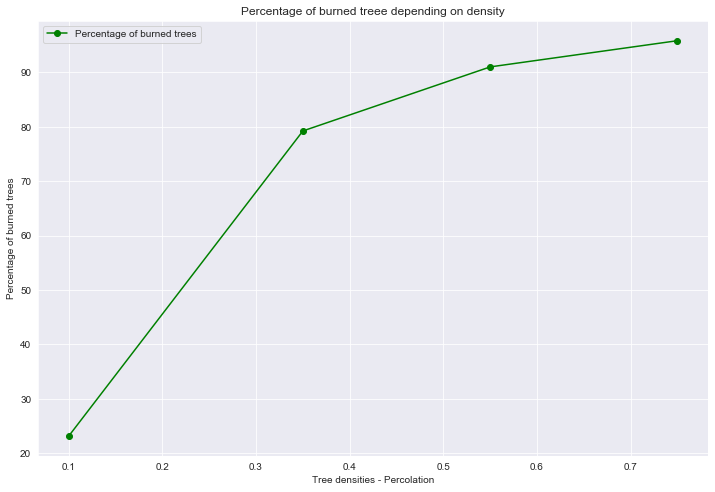

In [48]:
plt.figure(figsize=(12,8))
sb.set_style('darkgrid')
plt.plot(density_val, burn_tree, '-go')
plt.xlabel('Tree densities - Percolation')
plt.ylabel('Percentage of burned trees')
plt.title('Percentage of burned treee depending on density')
plt.legend(('Percentage of burned trees',))
plt.show()

Trend of burned trees

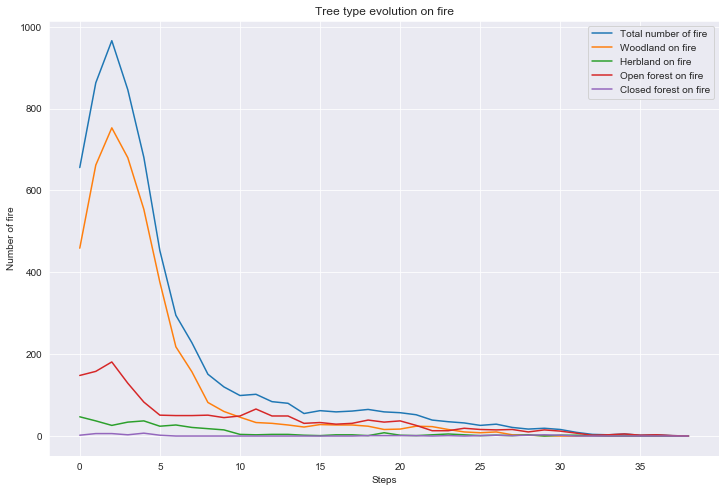

In [49]:
plt.figure(figsize=(12,8))
sb.set_style('darkgrid')
plt.plot(fire_list[1:])
plt.plot([woodland_list[i-1]-woodland_list[i] for i in range(1, len(woodland_list))])
plt.plot([herbland_list[i-1]-herbland_list[i] for i in range(1, len(herbland_list))])
plt.plot([open_forest_list[i-1]-open_forest_list[i] for i in range(1, len(open_forest_list))])
plt.plot([closed_forest_list[i-1]-closed_forest_list[i] for i in range(1, len(closed_forest_list))])
plt.legend(('Total number of fire', 'Woodland on fire', 'Herbland on fire', 'Open forest on fire', 'Closed forest on fire'))
plt.title('Tree type evolution on fire')
plt.xlabel('Steps')
plt.ylabel('Number of fire')
plt.show()